In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import zipfile
import os

# Path to zip file in Google Drive
zip_path = "/content/drive/MyDrive/test_set.zip"

# Destination folder
extract_path = "/content/data"

# Create folder if it doesn’t exist
os.makedirs(extract_path, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipped to:", extract_path)


KeyboardInterrupt: 

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
from torchvision.datasets import ImageFolder

# ✅ Custom dataset that skips corrupted/unreadable images
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)
            return sample, target
        except Exception as e:
            print(f"⚠️ Skipping corrupted file: {path} ({e})")
            # Pick another index instead of crashing
            new_index = (index + 1) % len(self.samples)
            return self.__getitem__(new_index)


In [34]:
# Base paths
base_path = "/content/data"
trainval_dir = os.path.join(base_path, "train_and_validation_sets/train_and_validation_sets")
test_dir = os.path.join(base_path, "test_set/test_set")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Use SafeImageFolder instead of ImageFolder
full_dataset = SafeImageFolder(trainval_dir, transform=transform)

# Train/Validation split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Train samples: 7672, Validation samples: 1918


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = full_dataset.targets
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class Weights:", class_weights)


Class Weights: tensor([0.4628, 0.9264, 2.2261, 3.2181], device='cuda:0')


In [36]:
# Load ResNet50 pretrained on ImageNet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Replace final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

# Loss + optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {"train_loss": [], "val_qwk": []}

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        history["train_loss"].append(avg_loss)

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        qwk = cohen_kappa_score(all_labels, all_preds, weights="quadratic")
        history["val_qwk"].append(qwk)

        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, QWK: {qwk:.4f}, Time: {elapsed:.2f}s")

    return model, history


In [38]:
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch 1/5, Loss: 0.8493, QWK: 0.8372, Time: 100.03s
Epoch 2/5, Loss: 0.5070, QWK: 0.8535, Time: 102.42s
Epoch 3/5, Loss: 0.3179, QWK: 0.8434, Time: 103.15s
Epoch 4/5, Loss: 0.1963, QWK: 0.8456, Time: 103.51s
Epoch 5/5, Loss: 0.1060, QWK: 0.8357, Time: 103.94s


In [39]:
test_dataset = SafeImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

qwk_test = cohen_kappa_score(all_labels, all_preds, weights="quadratic")
print("✅ Test QWK:", qwk_test)


⚠️ Skipping corrupted file: /content/data/test_set/test_set/Mayo 0/UC_patient_206_56.bmp (image file is truncated (202 bytes not processed))
⚠️ Skipping corrupted file: /content/data/test_set/test_set/Mayo 1/UC_patient_90_21.bmp (image file is truncated (138 bytes not processed))
✅ Test QWK: 0.807047237067291


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# ✅ Standard metrics
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# ✅ Convert to NumPy safely
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

# ✅ Ensure labels are from CPU (fixing your error)
if torch.is_tensor(labels):
    labels_np = labels.cpu().numpy()
else:
    labels_np = np.array(labels)

# ✅ Closeness Evaluation Measure (CEM)
cem = 1 - np.abs(all_preds_np - all_labels_np) / (len(np.unique(labels_np)) - 1)
cem_score = cem.mean()

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
      f"F1 Macro: {f1:.4f}, CEM: {cem_score:.4f}")


Precision: 0.6606, Recall: 0.6472, F1 Macro: 0.6518, CEM: nan


/tmp/ipython-input-571901682.py:20: RuntimeWarning: divide by zero encountered in divide
  cem = 1 - np.abs(all_preds_np - all_labels_np) / (len(np.unique(labels_np)) - 1)
/tmp/ipython-input-571901682.py:20: RuntimeWarning: invalid value encountered in divide
  cem = 1 - np.abs(all_preds_np - all_labels_np) / (len(np.unique(labels_np)) - 1)


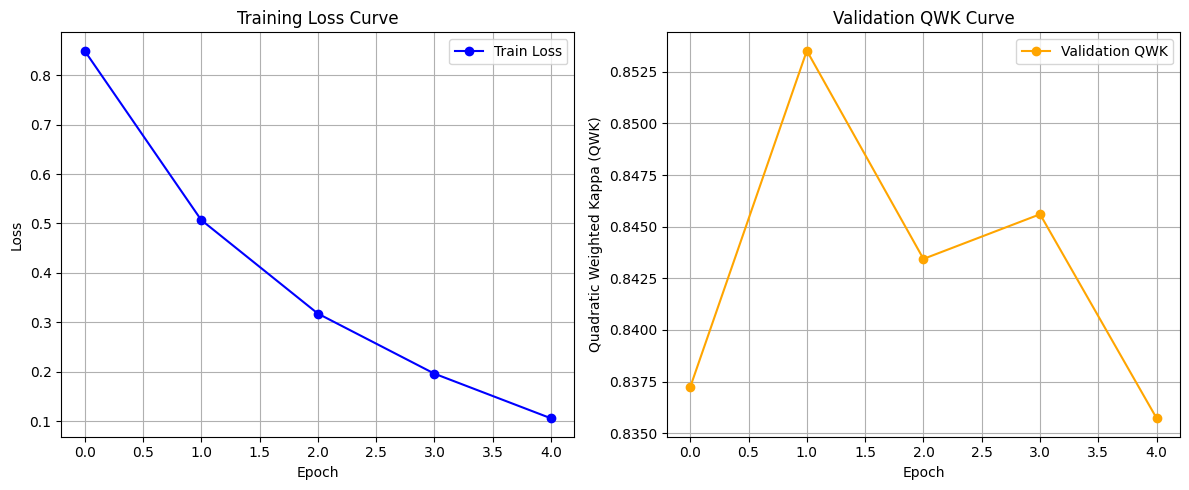

In [43]:
import matplotlib.pyplot as plt

# Training curves
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss", color="blue", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)

# Plot validation QWK
plt.subplot(1, 2, 2)
plt.plot(history["val_qwk"], label="Validation QWK", color="orange", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Quadratic Weighted Kappa (QWK)")
plt.title("Validation QWK Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
